# Proyecto de Clasificación de Imágenes: Evaluación y Comparación de Estrategias Basadas en Redes Neuronales Convolucionales (CNNs)

En este proyecto, se evaluaron y compararon dos estrategias distintas para la clasificación de imágenes utilizando redes neuronales convolucionales (CNNs). El objetivo era desarrollar y optimizar modelos de aprendizaje profundo siguiendo un pipeline estándar para tareas de inteligencia artificial. A continuación, se describen las etapas clave del proceso y las estrategias implementadas:

### Pipeline de Desarrollo
1. Carga del Conjunto de Datos: Inicio del proyecto con la importación y preparación del dataset asignado.
2. Inspección del Conjunto de Datos: Análisis exploratorio para comprender las características del dataset, incluyendo la distribución de clases y la calidad de las imágenes.
3. Acondicionamiento del Conjunto de Datos: Preprocesamiento de las imágenes, incluyendo técnicas como normalización, redimensionamiento y aumento de datos (data augmentation).
4. Desarrollo de la Arquitectura y Entrenamiento del Modelo: Diseño y entrenamiento de la red neuronal, con una monitorización constante del rendimiento para la toma de decisiones informadas durante el entrenamiento.
5. Evaluación del Modelo Predictivo: Evaluación de los resultados y precisión del modelo, seguida de la iteración para mejoras continuas.

### Estrategia 1: Entrenamiento desde Cero

La primera estrategia consistió en diseñar, entrenar y optimizar una red neuronal profunda desde cero. Se tomó un enfoque empírico para la selección de la arquitectura y los hiperparámetros finales, utilizando técnicas avanzadas de regularización como weight regularization, dropout, batch normalization y data augmentation para mejorar el rendimiento del modelo.

### Estrategia 2: Transfer Learning con Redes Pre-entrenadas

La segunda estrategia involucró el uso de redes preentrenadas en **ImageNet**, aplicando transfer learning y fine-tuning para adaptar los modelos a la tarea específica de clasificación. Se compararon múltiples arquitecturas, incluyendo VGG, ResNet50 y MobileNetV2. Se seleccionó la arquitectura que proporcionó la mayor precisión, y se aplicaron técnicas de regularización avanzadas para optimizar su rendimiento.

### Librerías utilizadas:

In [ ]:
import os
import shutil
import random
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, VGG16, ResNet50V2

import tensorflow as tf
from google.colab import files

### Funciones desarrolladas:

In [ ]:
def descargar_datos_kaggle(dataset_name: str,):
  data_folder = os.path.basename(dataset_name)

  if os.path.exists(data_folder):
    print(f'Este dataset ya existe. Si quieres volver a descargarlo elimina la carpeta: {data_folder}')
    return

  os.mkdir(data_folder)

  try:
    print('[INFO]: ------ DESCARGANDO DATOS ------')
    !kaggle competitions download -c plant-seedlings-classification --force

    print('\n[INFO]: ------ EXTRAYENDO DATOS ------')
    with zipfile.ZipFile('plant-seedlings-classification.zip', 'r') as zip_ref:
      zip_ref.extractall(f'./{data_folder}')

  except Exception as e:
    print(e)
  print('[INFO]: ------ DATOS LISTOS ------')

In [ ]:
# Mueve las imágenes a las carpetas correspondientes
def move_images_to_directory(images, labels, destination):
    for img, label in zip(images, labels):
        dest_dir = os.path.join(destination, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img, dest_dir)

In [ ]:
def mostrar_imagenes_por_clase(data_generator, labelNames):
    # Diccionario para almacenar una imagen de cada clase
    imagenes_por_clase = {label: None for label in labelNames}

    # Iteramos sobre el generador hasta que tengamos una imagen de cada clase
    for images, labels in data_generator:
        for img, label in zip(images, labels):
            class_index = label.argmax()
            class_name = labelNames[class_index]
            if imagenes_por_clase[class_name] is None:
                imagenes_por_clase[class_name] = img
            # Si ya tenemos una imagen para cada clase, rompemos el bucle
            if all(value is not None for value in imagenes_por_clase.values()):
                break
        if all(value is not None for value in imagenes_por_clase.values()):
            break

    # Crear figura para mostrar las imágenes
    fig = plt.figure(figsize=(14, 10))
    index = 1
    for label in labelNames:
        img = imagenes_por_clase[label]
        if img is not None:
            # Desnormalizar la imagen si está en el rango [0, 1]
            img = (img).astype('uint8')
            ax = fig.add_subplot(4, 3, index)
            ax.imshow(img)
            ax.set_title(label)
        else:
            ax = fig.add_subplot(4, 3, index)
            ax.set_title(f"No image for {label}")
        ax.axis("off")
        index += 1

    plt.subplots_adjust(hspace=0.2, wspace=0.00002)
    plt.show()

In [ ]:
# Función para ver si hay desbalance de clases
def muestras_por_clase(data_generator, nombre_dataset):
    print(f"Recuento y porcentaje de muestras por clase en {nombre_dataset}:")
    for clase, indice in data_generator.class_indices.items():
        # Cuenta el número de muestras de la clase actual
        conteo_clase = sum(1 for archivo in data_generator.filenames if archivo.split('/')[0] == clase)
        porcentaje = (conteo_clase / len(data_generator.filenames)) * 100
        print(f"- {clase}: {conteo_clase} ({porcentaje:.2f}% del total)")
    print("\n------------------------------------------------------------\n")

In [ ]:
def visualize_learning_curve(H):
  epochs = len(H.history["loss"])

  plt.style.use("ggplot")
  fig, axs = plt.subplots(2, 1, figsize=(5, 6))

  # Plotting loss
  axs[0].plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  axs[0].plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  axs[0].set_title("Training and Validation Loss")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].legend()

  # Plotting accuracy
  axs[1].plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  axs[1].plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  axs[1].set_title("Training and Validation Accuracy")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Accuracy")
  axs[1].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def model_train(model, data_train, batch_size, epochs, data_val, callbacks, lr):
  model.summary()

  # Compilar el modelo
  model.compile(optimizer=AdamW(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

  # Entrenar el modelo
  H = model.fit(
      data_train,
      steps_per_epoch=data_train.samples // batch_size,
      epochs=epochs,
      validation_data=data_val,
      validation_steps=data_val.samples // batch_size,
      callbacks=callbacks  # Usar los callbacks
  )

  visualize_learning_curve(H)

In [ ]:
def definir_callbacks(paciencia, ruta_modelo):
  from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

  # Crear un callback para guardar el modelo con la mejor precisión en validación
  checkpoint_callback = ModelCheckpoint(
      filepath=ruta_modelo,
      monitor='val_accuracy',  # Monitoriza la precisión en el conjunto de validación
      save_best_only=True,  # Guarda solo el mejor modelo
      mode='max',  # Selecciona el modelo con la máxima precisión
      verbose=1
  )

  # Crear un callbacks para early stopping
  earlystopping_callback = EarlyStopping(monitor='val_loss', patience=paciencia, restore_best_weights=True, verbose=1)

  return [checkpoint_callback, earlystopping_callback]

In [ ]:
def evaluartest(model, data_test):

# Cargar el mejor modelo guardado
    best_model = load_model(model)

    # Evaluar el modelo en test
    error_test, accuracy_test = best_model.evaluate(data_test, verbose=0)

    # Predicciones del modelo
    predictions = best_model.predict(data_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_test.classes
    class_labels = list(data_test.class_indices.keys())

    # Matriz de confusión
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    print(f' MODEL: {model} ')
    print(f'Error de test: {error_test:.4f}')
    print(f'Accuracy de test: {accuracy_test:.4f}')
    print('\nInforme de clasificación:')
    print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

### 1. **Carga** del conjunto de datos y **acondicionamiento**

In [ ]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/82.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105119 sha256=5e2c608225ddfe0fce303d3878a190a15886002db6974aad816e06b4fad8dc85
  Stored in directory: /root/.cache/pip/wheels/d7/54/06/8a8f40cb39536605feb9acaacd0237a95eba39e5065e6392f4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.14
    Uninstalling kaggle-1.6.14:
      Successfully uninstalled kaggle-1.6.14


Conexión a kaggle

In [ ]:
%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files

In [ ]:
archivo = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargar datos de Kaggle
dataset = 'kaggle/plant-seedlings-classification'

descargar_datos_kaggle(dataset_name=dataset)

[INFO]: ------ DESCARGANDO DATOS ------
100% 1.68G/1.69G [00:22<00:00, 102MB/s]
100% 1.69G/1.69G [00:22<00:00, 78.8MB/s]

[INFO]: ------ EXTRAYENDO DATOS ------
[INFO]: ------ DATOS LISTOS ------


Dado que la carpeta 'test' que ofrece kaggle solo contiene imagenes de un tipo de planta, se ha optado por utilizar los datos de la carpeta 'train' como si estos fuesen todos los datos, realizando una división de estos en 'train' y 'test'. Posteriormente los datos de 'train' también se dividen en 'train' y 'val'. Por lo que en este punto se ha realizado un **pequeño acondicionamiento de los datos**.

In [ ]:
# Directorio que contiene todas las imágenes (Usaremos las imagenes de la carpeta TRAIN y la dividiremos en train y test ya que la carpeta test no se tiene la etiqueta real)
data_dir = '/content/plant-seedlings-classification/train/'

# Lista de todas las imágenes en todas las subcarpetas
imagenes = []
etiquetas = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            if os.path.isfile(img_path) and (img_file.endswith(".jpg") or img_file.endswith(".png")):
                imagenes.append(img_path)
                etiquetas.append(label)

# Dividir el conjunto de datos en entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(
    imagenes, etiquetas, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Define el nombre de las carpetas
train_folder_name = 'train_data'
val_folder_name = 'validation_data'
test_folder_name = 'test_data'

# Construye las rutas completas
train_dir = os.path.join('/content/plant-seedlings-classification/', train_folder_name)
val_dir = os.path.join('/content/plant-seedlings-classification/', val_folder_name)
test_dir = os.path.join('/content/plant-seedlings-classification/', test_folder_name)

# Crea las carpetas si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

move_images_to_directory(train_images, train_labels, train_dir)
move_images_to_directory(val_images, val_labels, val_dir)
move_images_to_directory(test_images, test_labels, test_dir)

### 2.   **Inspección** del conjunto de datos

In [ ]:
# A continuación se utilizará la función ImageDataGenerator para cargar las imágenes de las carpetas creadas y poder visualizarlas

# Definir algunos parámetros
batch_size = 32
alto = 256
ancho = 256

# Configurar generadores de imágenes para importar los datos desde las nuevas carpetas creadas
data_train = ImageDataGenerator()
data_val = ImageDataGenerator()
data_test = ImageDataGenerator()

# Configurar generadores de datos (solo se modifica el tamaño de imagen)
data_train = data_train.flow_from_directory(
    train_dir,
    target_size=(alto,ancho),
    batch_size=batch_size,
    class_mode='categorical')

data_val = data_val.flow_from_directory(
    val_dir,
    target_size=(alto,ancho),
    batch_size=batch_size,
    class_mode='categorical')

data_test = data_test.flow_from_directory(
    test_dir,
    target_size=(alto,ancho),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) 

Found 3040 images belonging to 12 classes.
Found 760 images belonging to 12 classes.
Found 950 images belonging to 12 classes.


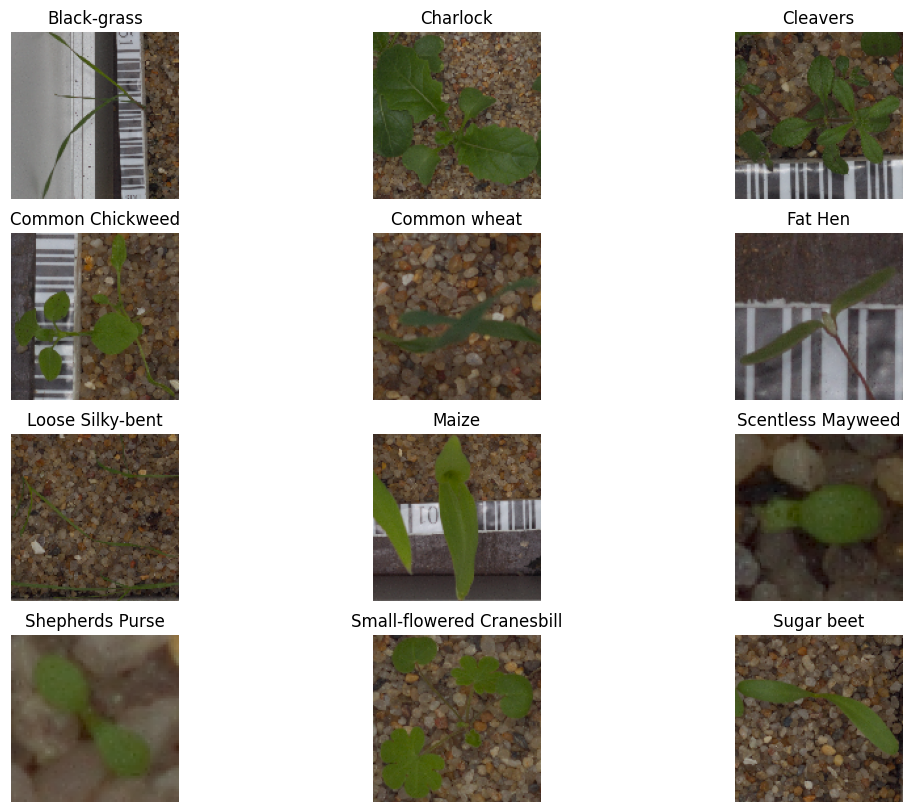

In [ ]:
# Obtener las clases (nombres de las carpetas en los directorios de datos)
labelNames = list(data_train.class_indices.keys())
# Mostrar una imagen de cada clase del conjunto de datos de entrenamiento
mostrar_imagenes_por_clase(data_train, labelNames)

Ver si existe desbalanceo entre clases o no:

In [ ]:
muestras_por_clase(data_train, 'TRAIN')
muestras_por_clase(data_val, 'VAL')
muestras_por_clase(data_test, 'TEST')

Recuento y porcentaje de muestras por clase en TRAIN:
- Black-grass: 172 (5.66% del total)
- Charlock: 252 (8.29% del total)
- Cleavers: 183 (6.02% del total)
- Common Chickweed: 381 (12.53% del total)
- Common wheat: 135 (4.44% del total)
- Fat Hen: 310 (10.20% del total)
- Loose Silky-bent: 421 (13.85% del total)
- Maize: 141 (4.64% del total)
- Scentless Mayweed: 310 (10.20% del total)
- Shepherds Purse: 152 (5.00% del total)
- Small-flowered Cranesbill: 329 (10.82% del total)
- Sugar beet: 254 (8.36% del total)

------------------------------------------------------------

Recuento y porcentaje de muestras por clase en VAL:
- Black-grass: 33 (4.34% del total)
- Charlock: 70 (9.21% del total)
- Cleavers: 47 (6.18% del total)
- Common Chickweed: 102 (13.42% del total)
- Common wheat: 35 (4.61% del total)
- Fat Hen: 84 (11.05% del total)
- Loose Silky-bent: 87 (11.45% del total)
- Maize: 38 (5.00% del total)
- Scentless Mayweed: 95 (12.50% del total)
- Shepherds Purse: 31 (4.08% del t

Como se puede ver, existen algunas diferencias en la representación de las clases, como por ejemplo:

- Common Chickweed y Loose Silky-bent tienen una representación algo superior en comparación con otras clases en todas las divisiones del conjunto de datos.
- Common wheat, Black-grass, Maize y Shepherds Purse tienen una representación algo inferior en comparación con otras clases.

A pesar de que no hay una clase con una representación extremadamente baja, este ligero desbalanceo entre clases puede influir en el rendimiento de los diferentes modelos, para intentar solventar esto se va a analizar el rendimiento de la red from scratch con y sin data augmentation para ver si se aprecian diferencias.

### 3.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución

In [ ]:
# Se establece una semilla para asegurar la reproducibilidad de los modelos entrenados a partir de este punto
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

#### 3.1. Red desde cero o *from scratch*

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 40
batch_size = 32
lr = 0.00001

# Red feedforward API secuencial
model = Sequential()

# BASE MODEL
## BM Bloque 1
model.add(Conv2D(32, (3,3), activation="relu", padding="same", input_shape=input))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

## BM Bloque 2
model.add(Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

## BM Bloque 3
model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

## BM Bloque 4
model.add(Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

## BM Bloque 5
model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

# TOP MODEL
model.add(GlobalAvgPool2D())
model.add(Dense(num_clases, activation="softmax"))


##### 3.1.1. Entrenamiento sin uso de data augmentacion

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
95/95 [==============================] - ETA: 0s - loss: 2.6674 - accuracy: 0.1832
Epoch 2: val_accuracy improved from 0.13179 to 0.19565, saving model to mejor_modelo_scratch_sinData.h5
95/95 [==============================] - 40s 426ms/step - loss: 2.6674 - accuracy: 0.1832 - val_loss: 2.4179 - val_accuracy: 0.1957
Epoch 3/40
95/95 [==============================] - ETA: 0s - loss: 2.3979 - accuracy: 0.2234
Epoch 3: val_accuracy improved from 0.19565 to 0.29348, saving model to mejor_modelo_scratch_sinData.h5
95/95 [==============================] - 44s 465ms/step - loss: 2.3979 - accuracy: 0.2234 - val_loss: 2.2335 - val_accuracy: 0.2935
Epoch 4/40
95/95 [==============================] - ETA: 0s - loss: 2.2112 - accuracy: 0.2937
Epoch 4: val_accuracy improved from 0.29348 to 0.33424, saving model to mejor_modelo_scratch_sinData.h5
95/95 [==============================] - 43s 451ms/step - loss: 2.2112 - accuracy: 0.2937 - val_loss: 2.0979 - val_accuracy: 0.3342
Epoch 5/40

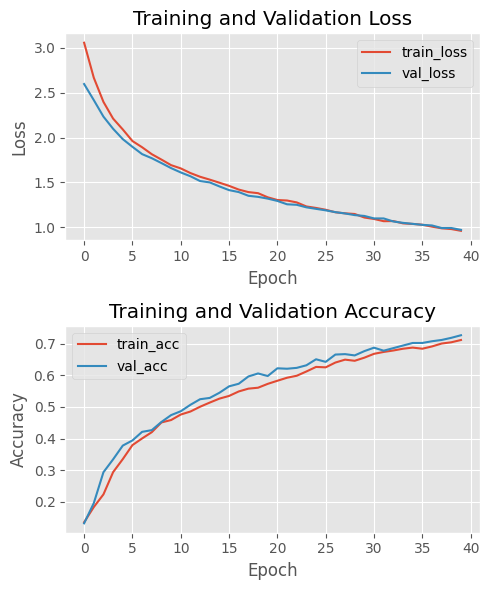

In [ ]:
# Entrenar la red con los datos sin usar el data augmentation
callbacks = definir_callbacks(9, 'mejor_modelo_scratch_sinData.h5')
model_train(model, data_train, batch_size, epochs, data_val, callbacks, lr)

##### 3.1.2. Entrenamiento usando data augmentacion

A continuación se va a utilizar data augmentation para ver si mejora el rendimiento del modelo:

In [ ]:
# Configurar generadores de imágenes con data augmentation para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Configurar generadores
data_train_aug = train_datagen.flow_from_directory(
    train_dir,
    target_size=(alto, ancho),
    batch_size=batch_size,
    class_mode='categorical')

data_val_aug = val_datagen.flow_from_directory(
    val_dir,
    target_size=(alto, ancho),
    batch_size=batch_size,
    class_mode='categorical')

data_test_aug = test_datagen.flow_from_directory(
    test_dir,
    target_size=(alto, ancho),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Obtener el orden de las clases
orden_clases = data_train.class_indices

# Invertir el diccionario para mapear de número de clase a nombre de clase
dic_clases = {i: class_name for class_name, i in orden_clases.items()}

# Definir el numero de clases que hay
num_clases = data_train.num_classes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - ETA: 0s - loss: 1.3137 - accuracy: 0.6003
Epoch 2: val_accuracy did not improve from 0.12772
95/95 [==============================] - 102s 1s/step - loss: 1.3137 - accuracy: 0.6003 - val_loss: 3.9308 - val_accuracy: 0.1264
Epoch 3/40
95/95 [==============================] - ETA: 0s - loss: 1.2563 - accuracy: 0.6220
Epoch 3: val_accuracy did not improve from 0.12772
95/95 [==============================] - 101s 1s/step - loss: 1.2563 - accuracy: 0.6220 - val_loss: 4.4905 - val_accuracy: 0.0421
Epoch 4/40
95/95 [==============================] - ETA: 0s - loss: 1.2327 - accuracy: 0.6342
Epoch 4: val_accuracy did not improve from 0.12772
95/95 [==============================] - 100s 1s/step - loss: 1.2327 - accuracy: 0.6342 - val_loss: 5.3393 - val_accuracy: 0.0448
Epoch 5/40
95/95 [==============================] - ETA: 0s - loss: 1.2067 - accuracy: 0.6362
Epoch 5: val_accuracy did not improve from 0.12772
95/95 [==============================] - 

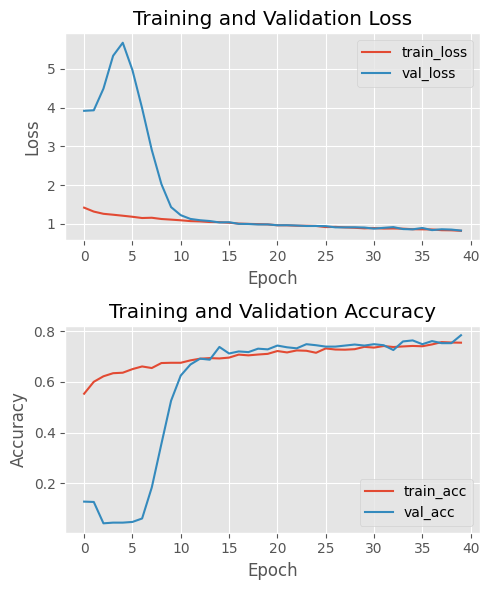

In [ ]:
# Entrenar la red con los datos usando el data augmentation
callbacks = definir_callbacks(9, 'mejor_modelo_scratch_conData.h5')
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.1.2. Evaluación de ambos modelos

 MODEL: /content/mejor_modelo_scratch_sinData.h5 
Error de test: 0.9180
Accuracy de test: 0.7379

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.5106    0.4800    0.4948        50
                 Charlock     0.7073    0.7838    0.7436        74
                 Cleavers     0.5846    0.8444    0.6909        45
         Common Chickweed     0.8222    0.9174    0.8672       121
             Common wheat     0.8108    0.7143    0.7595        42
                  Fat Hen     0.7753    0.6571    0.7113       105
         Loose Silky-bent     0.7973    0.8489    0.8223       139
                    Maize     0.7059    0.6667    0.6857        36
        Scentless Mayweed     0.7802    0.6636    0.7172       107
          Shepherds Purse     0.5000    0.3514    0.4127        37
Small-flowered Cranesbill     0.8100    0.7864    0.7980       103
               Sugar beet     0.6667    0.7033    0.6845        91

   

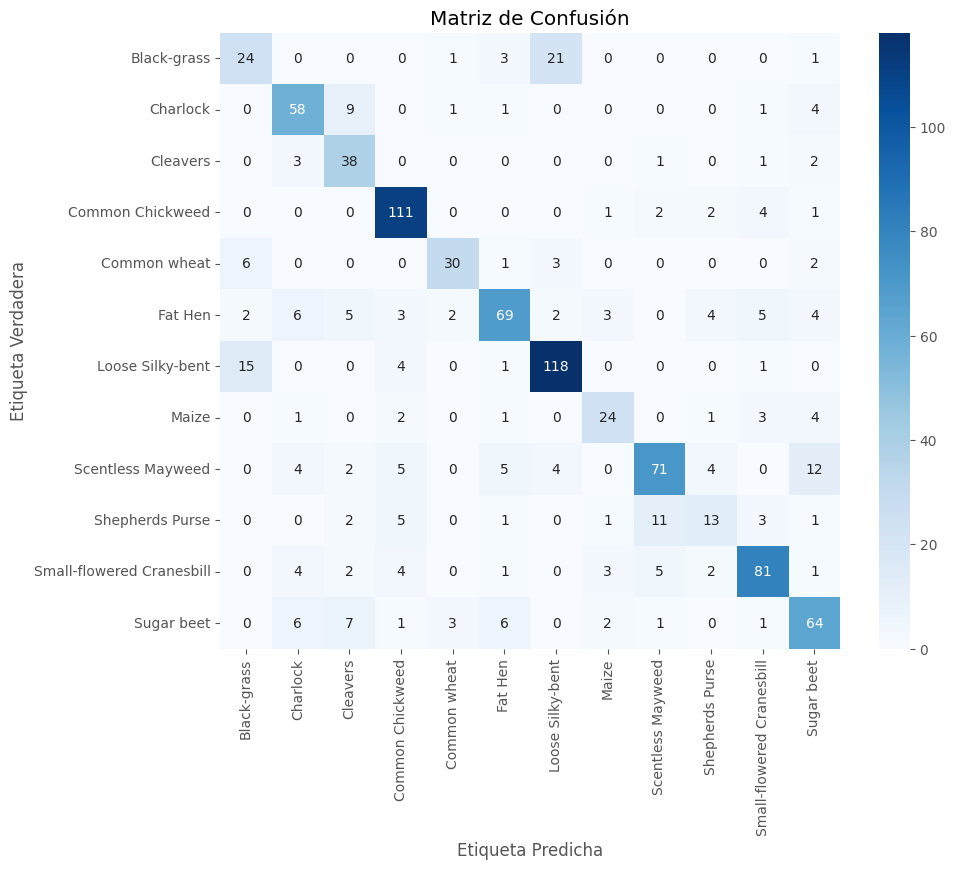

 MODEL: /content/mejor_modelo_scratch_conData.h5 
Error de test: 0.7924
Accuracy de test: 0.7758

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.5510    0.5400    0.5455        50
                 Charlock     0.7639    0.7432    0.7534        74
                 Cleavers     0.7778    0.7778    0.7778        45
         Common Chickweed     0.8430    0.8430    0.8430       121
             Common wheat     0.9355    0.6905    0.7945        42
                  Fat Hen     0.7788    0.8381    0.8073       105
         Loose Silky-bent     0.7987    0.8561    0.8264       139
                    Maize     0.6735    0.9167    0.7765        36
        Scentless Mayweed     0.7900    0.7383    0.7633       107
          Shepherds Purse     0.3500    0.1892    0.2456        37
Small-flowered Cranesbill     0.7778    0.8835    0.8273       103
               Sugar beet     0.8571    0.7912    0.8229        91

   

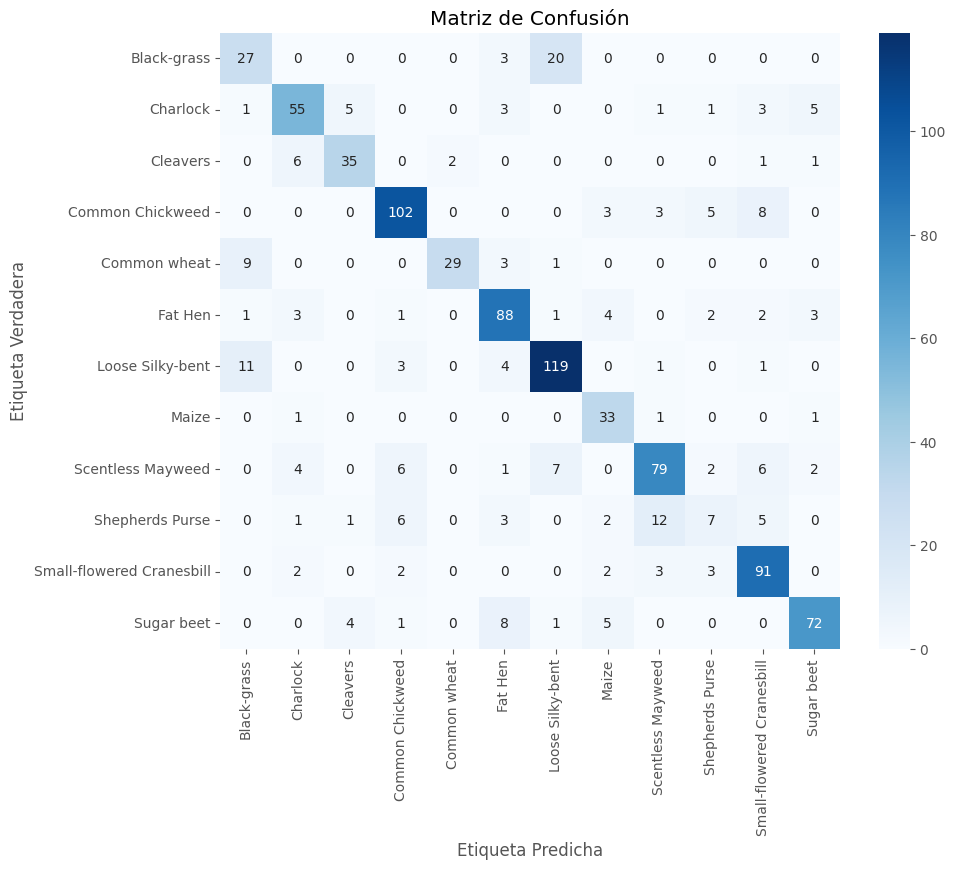

In [ ]:
## EVALUACION DE LOS MODELOS FROM SCRATCH
evaluartest('/content/mejor_modelo_scratch_sinData.h5', data_test)
evaluartest('/content/mejor_modelo_scratch_conData.h5', data_test_aug)

Conclusiones:
- **Red from scratch sin data augmentation:**

En la diagonal principal de la matriz de confusión se ve que las clases como Loose Silky-bent, Common Chickweed, y Scentless Mayweed tienen un número significativo de predicciones correctas lo que indica que el modelo las clasifica correctamente con mayor frecuencia.

Por otro lado, el modelo confunde algunos tipos de plantas como por ejemplo, Loose Silky-bent tiene 15 instancias clasificadas incorrectamente como Black-grass, esto puede ser debido a que ambas clases están menos presentes en los datos y son muy similares en cuanto a forma y tamaño.

En lineas generales, se ha conseguido una accuracy en test del **73.79%**

- **Red from scratch con data augmentation:**

Se sigue observando que el modelo sigue confundiendo y clasificando incorrectamente algunas clases pero por lo general el número de aciertos en la diagonal principal es mayor, consiguiendo ahora una accuracy en test del **77.58%**

**Debido al aumento de rendimiento gracias al uso de data augmentation, a partir de ahora todos los modelos se entrenaran usando data augmentation.**

#### 3.2. Uso de arquitecturas pre-entrenadas para **Transfer Learning**

##### 3.2.1. RED PRE-ENTRENADA **MOBILE NET**

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 30
batch_size = 64
lr = 0.0001

callbacks = definir_callbacks(9, 'mejor_modelo_mobilenet.h5') # Guardar el mejor modelo

# Cargar el modelo base MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input)

# Congelar las capas del modelo base
base_model.trainable = False

# Model Base + Top Model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 1)),
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dense(num_clases, activation='softmax')
])


17225924/17225924 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          589888    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 2, 2, 128)         0         
 g2D)                                                            
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



47/47 [==============================] - 179s 4s/step - loss: 2.2351 - accuracy: 0.2693 - val_loss: 2.4757 - val_accuracy: 0.2017
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 1.4478 - accuracy: 0.5173
Epoch 2: val_accuracy improved from 0.20170 to 0.26420, saving model to mejor_modelo_mobilenet.h5
47/47 [==============================] - 181s 4s/step - loss: 1.4478 - accuracy: 0.5173 - val_loss: 2.1081 - val_accuracy: 0.2642
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 1.1485 - accuracy: 0.6097
Epoch 3: val_accuracy improved from 0.26420 to 0.48295, saving model to mejor_modelo_mobilenet.h5
47/47 [==============================] - 186s 4s/step - loss: 1.1485 - accuracy: 0.6097 - val_loss: 1.5784 - val_accuracy: 0.4830
Epoch 4/30
47/47 [==============================] - ETA: 0s - loss: 0.9433 - accuracy: 0.6715
Epoch 4: val_accuracy improved from 0.48295 to 0.

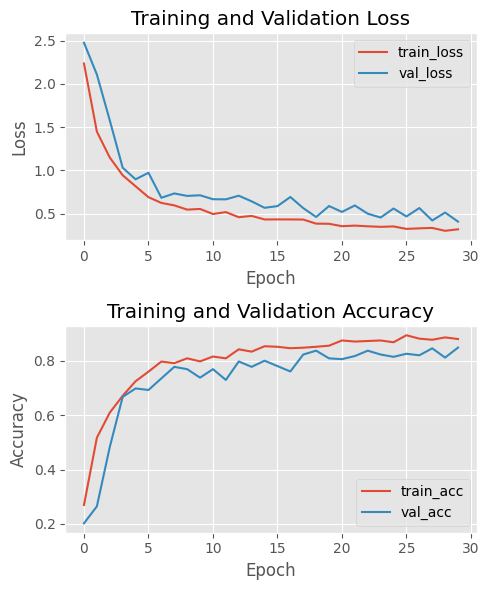

In [ ]:
# Entrenar el modelo
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.2.2. RED PRE-ENTRENADA **VGG16**

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 30
batch_size = 64
lr = 0.0001

callbacks = definir_callbacks(8, 'mejor_modelo_vgg16.h5') # Guardar el mejor modelo

# Cargar el modelo base MobileNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input)

# Congelar las capas del modelo base
base_model.trainable = False

# Model Base + Top Model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 1)), 
    Dropout(0.3),
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dense(num_clases, activation='softmax')])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          294976    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 2, 2, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 256)        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



47/47 [==============================] - 66s 1s/step - loss: 2.6042 - accuracy: 0.1164 - val_loss: 2.4856 - val_accuracy: 0.1051
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 2.2301 - accuracy: 0.2380
Epoch 2: val_accuracy improved from 0.10511 to 0.29261, saving model to mejor_modelo_vgg16.h5
47/47 [==============================] - 50s 1s/step - loss: 2.2301 - accuracy: 0.2380 - val_loss: 2.3612 - val_accuracy: 0.2926
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 2.0469 - accuracy: 0.2906
Epoch 3: val_accuracy improved from 0.29261 to 0.30114, saving model to mejor_modelo_vgg16.h5
47/47 [==============================] - 51s 1s/step - loss: 2.0469 - accuracy: 0.2906 - val_loss: 2.2764 - val_accuracy: 0.3011
Epoch 4/30
47/47 [==============================] - ETA: 0s - loss: 1.8849 - accuracy: 0.3451
Epoch 4: val_accuracy improved from 0.30114 to 0.32102, savi

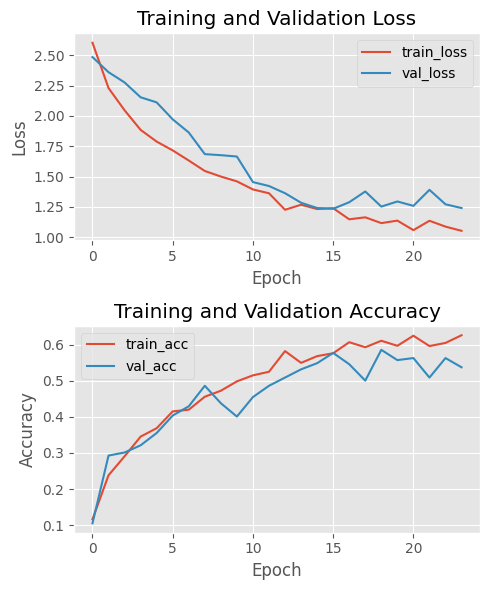

In [ ]:
# Entrenar el modelo
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.2.3. RED PRE-ENTRENADA **RESNET**

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 30
batch_size = 64
lr = 0.0001

callbacks = definir_callbacks(15, 'mejor_modelo_resnet.h5') # Guardar el mejor modelo

# Cargar el modelo base MobileNet
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input)

# Congelar las capas del modelo base
base_model.trainable = False

# Model Base + Top Model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 1)), 
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dense(num_clases, activation='softmax')])

94668760/94668760 [==============================] - 5s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          1179712   
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 2, 2, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 256)        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



47/47 [==============================] - 59s 1s/step - loss: 2.3238 - accuracy: 0.2460 - val_loss: 2.3652 - val_accuracy: 0.2670
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 1.5714 - accuracy: 0.4674
Epoch 2: val_accuracy improved from 0.26705 to 0.44602, saving model to mejor_modelo_resnet.h5
47/47 [==============================] - 51s 1s/step - loss: 1.5714 - accuracy: 0.4674 - val_loss: 1.7040 - val_accuracy: 0.4460
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 1.2444 - accuracy: 0.5851
Epoch 3: val_accuracy improved from 0.44602 to 0.50852, saving model to mejor_modelo_resnet.h5
47/47 [==============================] - 49s 1s/step - loss: 1.2444 - accuracy: 0.5851 - val_loss: 1.5509 - val_accuracy: 0.5085
Epoch 4/30
47/47 [==============================] - ETA: 0s - loss: 1.0500 - accuracy: 0.6270
Epoch 4: val_accuracy improved from 0.50852 to 0.58239, sa

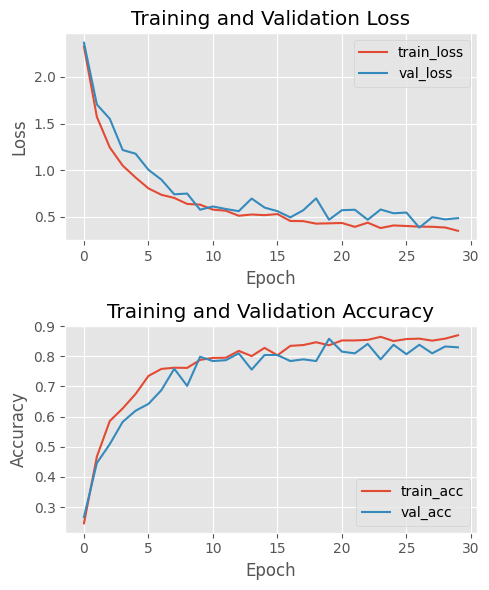

In [ ]:
# Entrenar el modelo
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.2.4. Evaluación de modelos con arquitecturas pre-entrenadas

 MODEL: /content/mejor_modelo_mobilenet.h5 
Error de test: 0.2766
Accuracy de test: 0.8989

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.5818    0.6400    0.6095        50
                 Charlock     0.9600    0.9730    0.9664        74
                 Cleavers     0.8431    0.9556    0.8958        45
         Common Chickweed     0.9504    0.9504    0.9504       121
             Common wheat     0.8837    0.9048    0.8941        42
                  Fat Hen     0.9785    0.8667    0.9192       105
         Loose Silky-bent     0.8380    0.8561    0.8470       139
                    Maize     0.9706    0.9167    0.9429        36
        Scentless Mayweed     0.8807    0.8972    0.8889       107
          Shepherds Purse     0.9643    0.7297    0.8308        37
Small-flowered Cranesbill     0.9717    1.0000    0.9856       103
               Sugar beet     0.9140    0.9341    0.9239        91

         

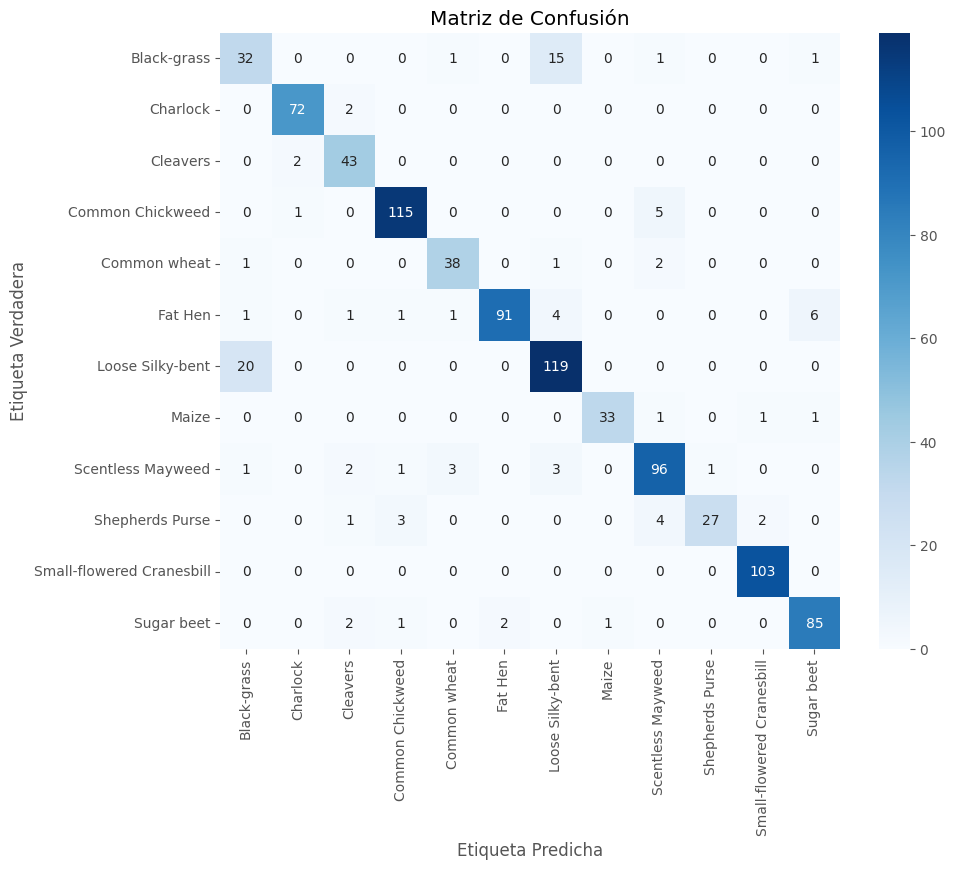

 MODEL: /content/mejor_modelo_vgg16.h5 
Error de test: 1.0477
Accuracy de test: 0.6558

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.7778    0.1400    0.2373        50
                 Charlock     0.9000    0.6081    0.7258        74
                 Cleavers     0.8125    0.5778    0.6753        45
         Common Chickweed     0.5367    0.9669    0.6903       121
             Common wheat     0.6038    0.7619    0.6737        42
                  Fat Hen     0.6737    0.6095    0.6400       105
         Loose Silky-bent     0.5748    0.8849    0.6969       139
                    Maize     0.6098    0.6944    0.6494        36
        Scentless Mayweed     0.5873    0.3458    0.4353       107
          Shepherds Purse     0.5000    0.0270    0.0513        37
Small-flowered Cranesbill     0.8876    0.7670    0.8229       103
               Sugar beet     0.7976    0.7363    0.7657        91

             

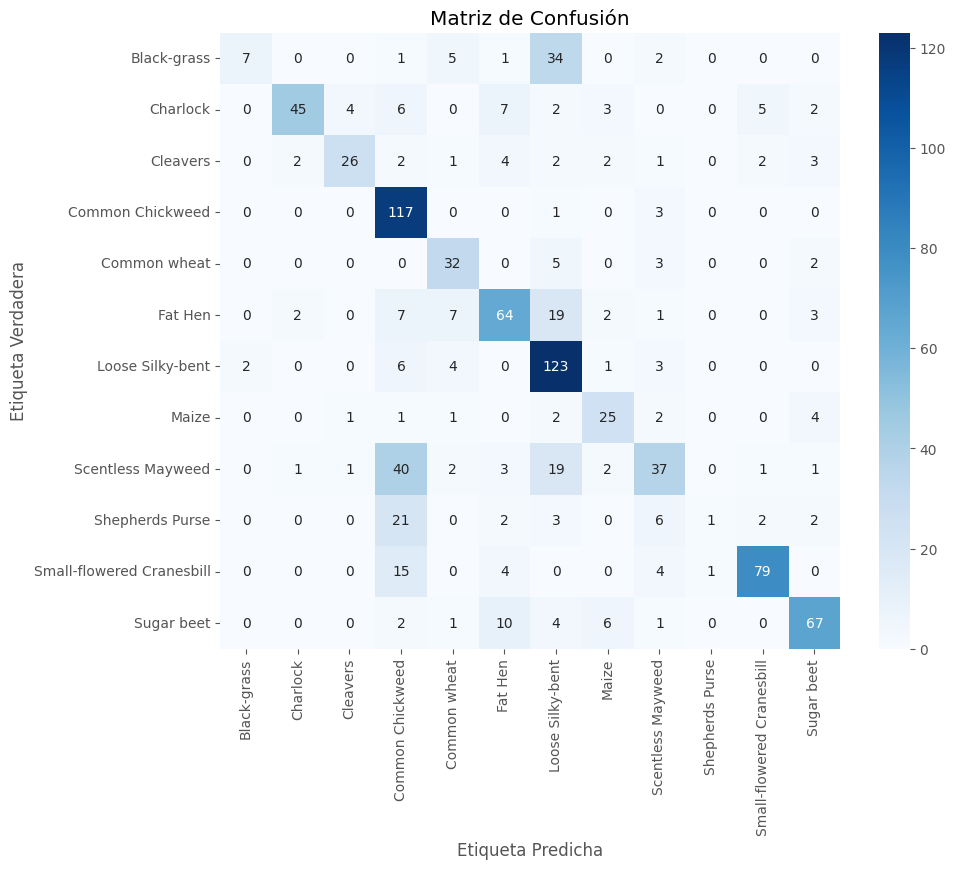

 MODEL: /content/mejor_modelo_resnet.h5 
Error de test: 0.3372
Accuracy de test: 0.8895

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.6275    0.6400    0.6337        50
                 Charlock     0.9474    0.9730    0.9600        74
                 Cleavers     0.9524    0.8889    0.9195        45
         Common Chickweed     0.9127    0.9504    0.9312       121
             Common wheat     0.8837    0.9048    0.8941        42
                  Fat Hen     0.9174    0.9524    0.9346       105
         Loose Silky-bent     0.8219    0.8633    0.8421       139
                    Maize     0.9189    0.9444    0.9315        36
        Scentless Mayweed     0.9205    0.7570    0.8308       107
          Shepherds Purse     0.7105    0.7297    0.7200        37
Small-flowered Cranesbill     0.9533    0.9903    0.9714       103
               Sugar beet     0.9655    0.9231    0.9438        91

            

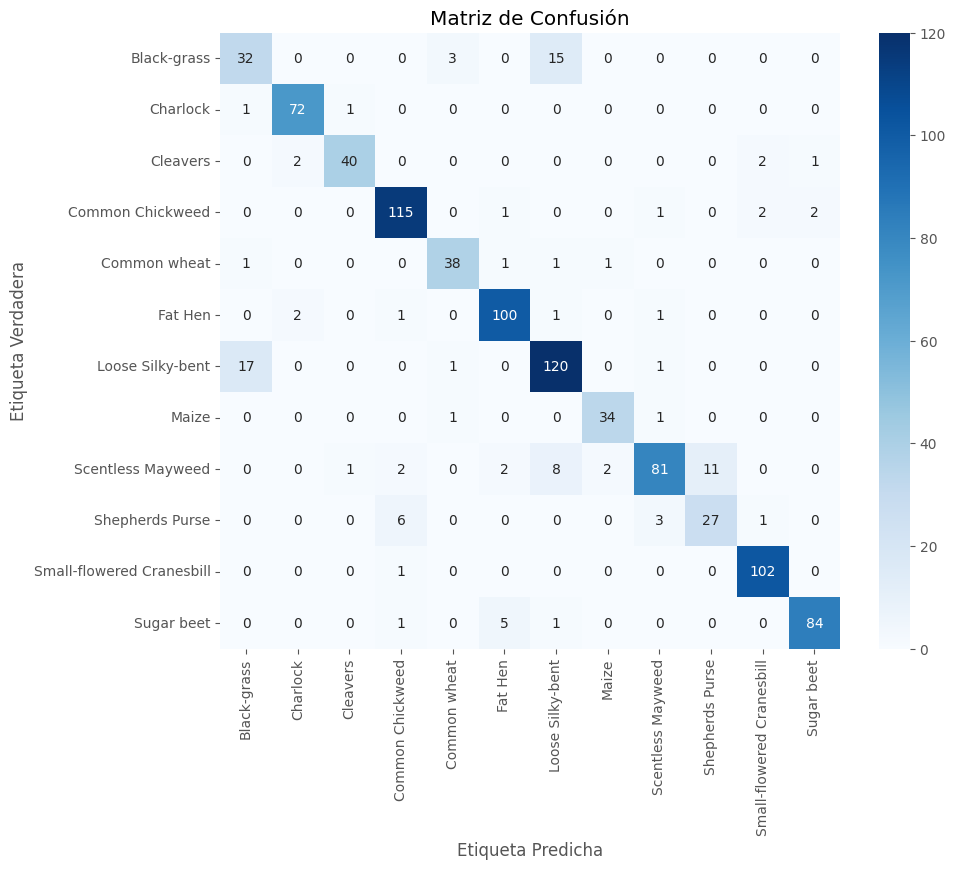

In [ ]:
## EVALUAR MODELOS TRANSFER-LEARNING
evaluartest('/content/mejor_modelo_mobilenet.h5', data_test_aug)
evaluartest('/content/mejor_modelo_vgg16.h5', data_test_aug)
evaluartest('/content/mejor_modelo_resnet.h5', data_test_aug)

#### 3.3. Uso de **Fine Tuning** para diferentes arquitecturas

Según lo comentado en clase, para el Fine Tuning solo se van a volver a entrenar las capas de **batch normalization** ya que estas calculan y almacenan estadísticas de los datos durante el entrenamiento, por lo que, al entrenar el modelo en un nuevo dominio de datos, estas características serán diferentes. Por tanto, se opta por entrenar solo las capas de **BatchNorm** para permitir que el modelo se adapte mejor a las nuevas estadísticas sin alterar los pesos previamente aprendidos en las otras capas.

##### 3.3.1. **Mobile Net Fine Tuning**

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 30
batch_size=64
lr = 0.0001

callbacks = definir_callbacks(15, 'mejor_modelo_mobilenet_finetuning.h5') # Guardar el mejor modelo

# Cargar el modelo base MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input)

# Descongelar el modelo
base_model.trainable = True

# Congelar capas menos las de batch normalization para fine-tuning
target = "bn"
for layer in base_model.layers:
  if target in layer.name:
    print("Capa " + layer.name + " descongelada...")
    continue
  layer.trainable = False


# Model Base + Top Model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 1)),
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dense(num_clases, activation='softmax')])

Capa conv1_bn descongelada...
Capa conv_dw_1_bn descongelada...
Capa conv_pw_1_bn descongelada...
Capa conv_dw_2_bn descongelada...
Capa conv_pw_2_bn descongelada...
Capa conv_dw_3_bn descongelada...
Capa conv_pw_3_bn descongelada...
Capa conv_dw_4_bn descongelada...
Capa conv_pw_4_bn descongelada...
Capa conv_dw_5_bn descongelada...
Capa conv_pw_5_bn descongelada...
Capa conv_dw_6_bn descongelada...
Capa conv_pw_6_bn descongelada...
Capa conv_dw_7_bn descongelada...
Capa conv_pw_7_bn descongelada...
Capa conv_dw_8_bn descongelada...
Capa conv_pw_8_bn descongelada...
Capa conv_dw_9_bn descongelada...
Capa conv_pw_9_bn descongelada...
Capa conv_dw_10_bn descongelada...
Capa conv_pw_10_bn descongelada...
Capa conv_dw_11_bn descongelada...
Capa conv_pw_11_bn descongelada...
Capa conv_dw_12_bn descongelada...
Capa conv_pw_12_bn descongelada...
Capa conv_dw_13_bn descongelada...
Capa conv_pw_13_bn descongelada...


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 64)          589888    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 2, 2, 128)         0         
 ng2D)                                                           
                                                      

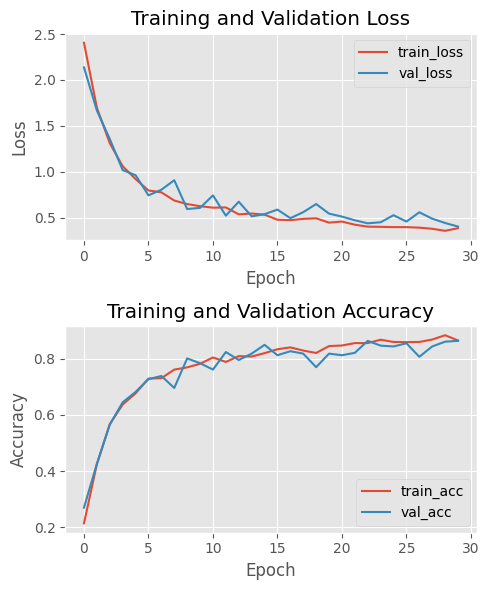

In [ ]:
# Entrenar el modelo
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.3.2. **VGG Fine Tuning**

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 40
batch_size = 64
lr = 0.00001

callbacks = definir_callbacks(15, 'mejor_modelo_vgg16_finetuning.h5') # Guardar el mejor modelo

# Cargar el modelo base VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input)

# Descongelar el modelo
base_model.trainable = True

# Congelar capas menos las de batch normalization para fine-tuning
target = "bn"
for layer in base_model.layers:
  if target in layer.name:
    print("Capa " + layer.name + " descongelada...")
    continue
  layer.trainable = False

# Model Base + Top Model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 1)),
    Dropout(0.3),
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dense(num_clases, activation='softmax')])


Capa input_4 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Capa block5_conv1 congelada...
Capa block5_conv2 congelada...
Capa block5_conv3 congelada...
Capa block5_pool congelada...


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 64)          294976    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 2, 2, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 2, 2, 256)        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



47/47 [==============================] - 65s 1s/step - loss: 2.7840 - accuracy: 0.0778 - val_loss: 2.5104 - val_accuracy: 0.0739
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 2.6900 - accuracy: 0.0991
Epoch 2: val_accuracy improved from 0.07386 to 0.11364, saving model to mejor_modelo_vgg16_finetuning.h5
47/47 [==============================] - 60s 1s/step - loss: 2.6900 - accuracy: 0.0991 - val_loss: 2.4867 - val_accuracy: 0.1136
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 2.6539 - accuracy: 0.0971
Epoch 3: val_accuracy improved from 0.11364 to 0.15057, saving model to mejor_modelo_vgg16_finetuning.h5
47/47 [==============================] - 53s 1s/step - loss: 2.6539 - accuracy: 0.0971 - val_loss: 2.4532 - val_accuracy: 0.1506
Epoch 4/40
47/47 [==============================] - ETA: 0s - loss: 2.5574 - accuracy: 0.1250
Epoch 4: val_accuracy improved from 0.

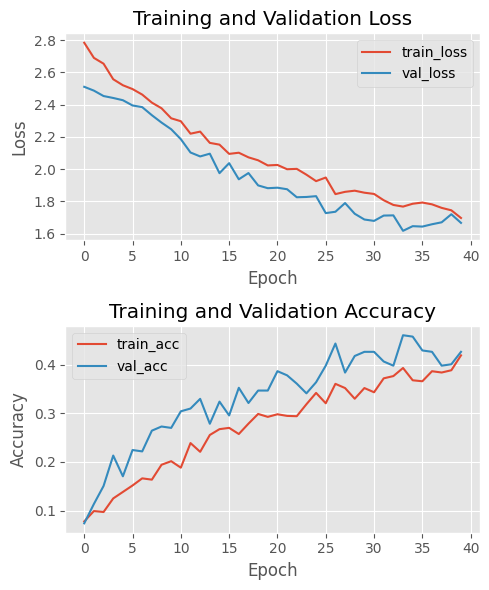

In [ ]:
# Entrenar el modelo
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.3.3. **RESNET Fine Tuning**

In [ ]:
# Arquitetura de la red

# Definir hiperparámetros
input = (alto, ancho, 3)
num_clases = 12
epochs = 40
batch_size=64
lr = 0.00001

callbacks = definir_callbacks(15, 'mejor_modelo_resnet_finetuning.h5') # Guardar el mejor modelo

# Cargar el modelo base ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input)

# Descongelar el modelo
base_model.trainable = True

# Congelar capas menos las de batch normalization para fine-tuning
target = "bn"
for layer in base_model.layers:
  if target in layer.name:
    print("Capa " + layer.name + " descongelada...")
    continue
  layer.trainable = False

# Model Base + Top Model
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((1, 1)),
    Flatten(),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dense(num_clases, activation='softmax')])


Capa conv2_block1_preact_bn descongelada...
Capa conv2_block1_1_bn descongelada...
Capa conv2_block1_2_bn descongelada...
Capa conv2_block2_preact_bn descongelada...
Capa conv2_block2_1_bn descongelada...
Capa conv2_block2_2_bn descongelada...
Capa conv2_block3_preact_bn descongelada...
Capa conv2_block3_1_bn descongelada...
Capa conv2_block3_2_bn descongelada...
Capa conv3_block1_preact_bn descongelada...
Capa conv3_block1_1_bn descongelada...
Capa conv3_block1_2_bn descongelada...
Capa conv3_block2_preact_bn descongelada...
Capa conv3_block2_1_bn descongelada...
Capa conv3_block2_2_bn descongelada...
Capa conv3_block3_preact_bn descongelada...
Capa conv3_block3_1_bn descongelada...
Capa conv3_block3_2_bn descongelada...
Capa conv3_block4_preact_bn descongelada...
Capa conv3_block4_1_bn descongelada...
Capa conv3_block4_2_bn descongelada...
Capa conv4_block1_preact_bn descongelada...
Capa conv4_block1_1_bn descongelada...
Capa conv4_block1_2_bn descongelada...
Capa conv4_block2_preact

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 64)          1179712   
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 4, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 2, 2, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 2, 2, 256)        

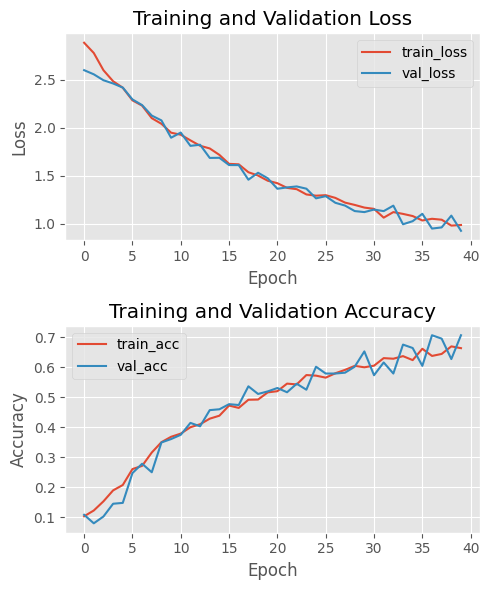

In [ ]:
# Entrenar el modelo
model_train(model, data_train_aug, batch_size, epochs, data_val_aug, callbacks, lr)

##### 3.3.4. Evaluación de modelos con **Fine Tuning**

 MODEL: /content/mejor_modelo_mobilenet_finetuning.h5 
Error de test: 0.3850
Accuracy de test: 0.8716

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.7222    0.2600    0.3824        50
                 Charlock     1.0000    0.9324    0.9650        74
                 Cleavers     0.9556    0.9556    0.9556        45
         Common Chickweed     0.8750    0.9256    0.8996       121
             Common wheat     0.9310    0.6429    0.7606        42
                  Fat Hen     0.9057    0.9143    0.9100       105
         Loose Silky-bent     0.7500    0.8849    0.8119       139
                    Maize     0.9722    0.9722    0.9722        36
        Scentless Mayweed     0.7680    0.8972    0.8276       107
          Shepherds Purse     0.7895    0.8108    0.8000        37
Small-flowered Cranesbill     1.0000    0.9806    0.9902       103
               Sugar beet     0.9121    0.9121    0.9121        91

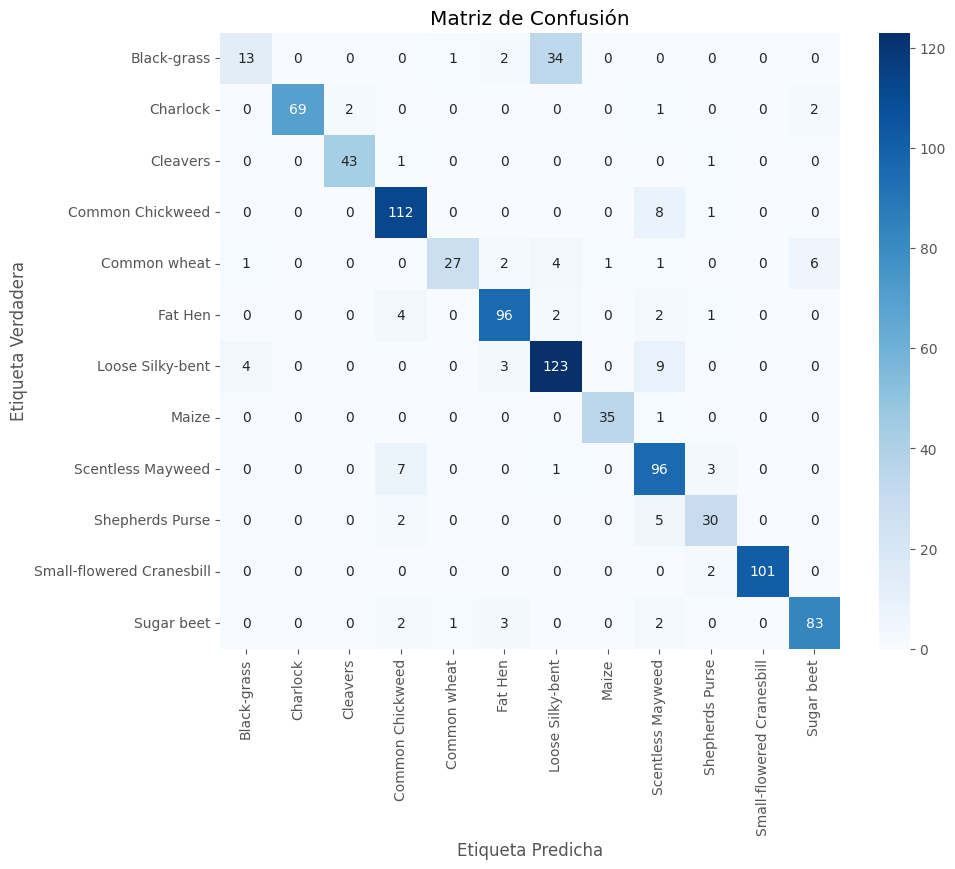

 MODEL: /content/mejor_modelo_vgg16_finetuning.h5 
Error de test: 1.5882
Accuracy de test: 0.4653

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.4167    0.2000    0.2703        50
                 Charlock     0.4225    0.4054    0.4138        74
                 Cleavers     0.5000    0.0667    0.1176        45
         Common Chickweed     0.4084    0.6446    0.5000       121
             Common wheat     0.6250    0.1190    0.2000        42
                  Fat Hen     0.5476    0.2190    0.3129       105
         Loose Silky-bent     0.4106    0.7266    0.5247       139
                    Maize     0.5000    0.3333    0.4000        36
        Scentless Mayweed     0.3446    0.5701    0.4296       107
          Shepherds Purse     0.0000    0.0000    0.0000        37
Small-flowered Cranesbill     0.8333    0.5825    0.6857       103
               Sugar beet     0.6860    0.6484    0.6667        91

  

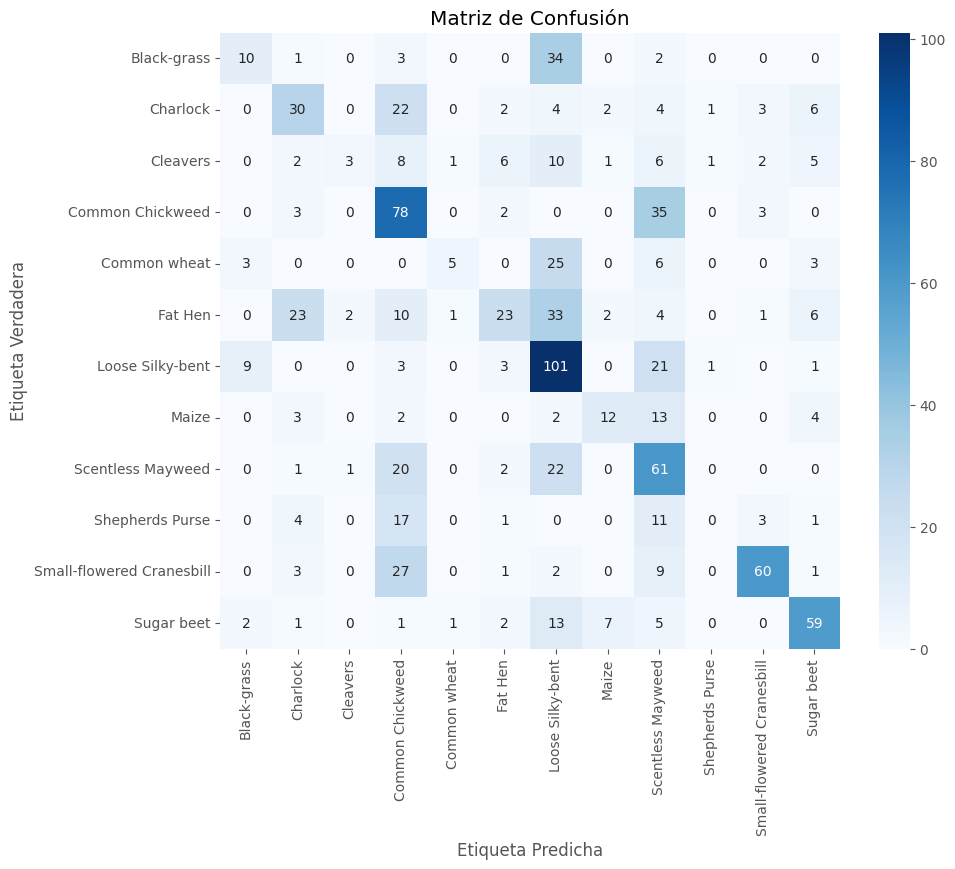

 MODEL: /content/mejor_modelo_resnet_finetuning.h5 
Error de test: 0.7597
Accuracy de test: 0.7432

Informe de clasificación:
                           precision    recall  f1-score   support

              Black-grass     0.3750    0.3000    0.3333        50
                 Charlock     0.7765    0.8919    0.8302        74
                 Cleavers     0.9394    0.6889    0.7949        45
         Common Chickweed     0.7812    0.8264    0.8032       121
             Common wheat     0.7273    0.3810    0.5000        42
                  Fat Hen     0.7912    0.6857    0.7347       105
         Loose Silky-bent     0.6807    0.8129    0.7410       139
                    Maize     0.6818    0.8333    0.7500        36
        Scentless Mayweed     0.7333    0.7196    0.7264       107
          Shepherds Purse     0.6667    0.4324    0.5246        37
Small-flowered Cranesbill     0.8276    0.9320    0.8767       103
               Sugar beet     0.7708    0.8132    0.7914        91

 

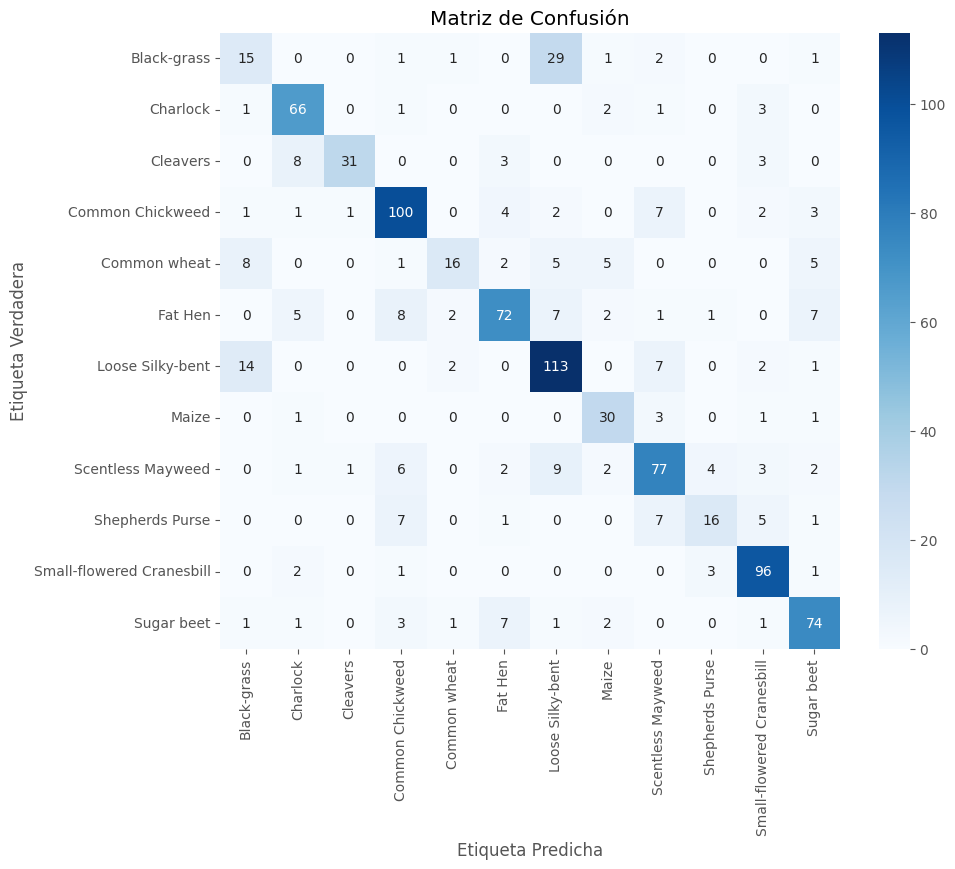

In [ ]:
## EVALUAR MODELOS DE FINE-TUNING
evaluartest('/content/mejor_modelo_mobilenet_finetuning.h5', data_test_aug)
evaluartest('/content/mejor_modelo_vgg16_finetuning.h5', data_test_aug)
evaluartest('/content/mejor_modelo_resnet_finetuning.h5', data_test_aug)

### 4. **Resumen** de la evaluación de los modelos

| Modelo                        | Precision | Recall | F1-score 
|-------------------------------|-----------|--------|----------|
| **Red from scratch:**         |                               |
| Sin Data Aug.                 |   0.7384  |0.7379  | 0.7346   |
| Con Data Aug.                 |   0.7716  | 0.7758 | 0.7704   |
| **Transfer Learning:**        |                               |
| Mobile Net                    |   0.9027  | 0.8989 |0.8995    |
| VGG16                         |   0.6845  | 0.6558 |   0.6296 |
| ResNet                        |    0.8909 |  0.8895|   0.8890 |
| **Fine Tuning:**              |                               |
| Mobile Net                    |    0.8735 | 0.8716 |   0.8641 |
| VGG16                         |   0.4926  | 0.4653 | 0.4377   |
| ResNet                        |   0.7414  |  0.7432|0.7354    |

- Para la red creada from scratch, se puede ver lo anteriormente nombrado, se tiene un mejor rendimiento usando data augmentation, por lo que se decidió aplicar esta técnica al entrenamiento del resto de los modelos posteriores.

- Se puede observar que los modelos de Transfer Learning ofreces unos mejores resultados que los de Fine Tuning, esto se puede deber a que los modelos de Transfer Learning son capaces de obtener mejores resultados ya que aprovechan las características generales aprendidas de grandes conjuntos de datos, evitando problemas de overfitting y errores de hiperparámetros. Para el caso de Fine Tuning, este requiere una configuración de hiperparámetros más exhaustiva y puede que por esto sus resultados sean peores.



**Nota:** Estas métricas han sido obtenidas tras realizar varios entrenamientos de los distintos modelos, para así, poder configurar de la mejor forma posible los distintos hiperparámetros.


### 5. **Conclusiones**

Conclusiones del análisis de los modelos de clasificación de imágenes:

**Red from scratch:**

Incorporar técnicas de data augmentation ha mejorado notablemente el rendimiento de la red, esto se puede ver ya que hay un aumento en la precisión, recall y F1-score en comparación con la versión sin data augmentation.
Data augmentation es una estrategia esencial para mejorar la generalización del modelo e intentar reducir el sobreajuste en el entrenamiento.

**Transfer Learning:**

Modelos como MobileNet y ResNet, pre-entrenados en grandes conjuntos de datos, proporcionan un rendimiento superior en términos de precisión, recall y F1-score en comparación con VGG16.
 
La utilización de Transfer Learning ha permitido aprovechar el conocimiento previo de estas arquitecturas entrenadas en conjuntos de datos masivos. Esto proporciona en una mejora significativa en la capacidad de generalización del modelo.

**Fine Tuning:**

El Fine Tuning de modelos pre-entrenados como MobileNet y ResNet ha permitido obtener mejoras en el rendimiento del modelo en comparación con VGG16. Para esta última se ha intentado usar técnicas de regularización como un 'DropOut' para intentar reducir el sobre ajuste y mejorar su rendimiento, aun así, no se han conseguido buenos resultados. Es posible que debido a que VGG16 posee una arquitectura más profunda y tiene más parámetros en comparación con MobileNet y ResNet sea más difícil de ajustar a otros dominios de datos.

La estrategia de la selección de capas con BatchNormalization para Fine Tuning ha demostrado ser efectiva ya que, aun que se tiene un peor rendimiento que en Transfer Learning, se ha conseguido aumentar el rendimiento del modelo con una inversión de tiempo menor.